In [162]:
from citalopram_project.load import load_neurons
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style("whitegrid")
from pathlib import Path

FIG_DIR = Path(r"C:\Users\roryl\repos\citalopram-project\figs\f1")

In [161]:
neurons = (
    load_neurons()
    .dropna()
    .loc[lambda x: x.group.isin(["sal", "continuation"])]
    .assign(group=lambda x: pd.Categorical(x.group, categories=["sal", "continuation"], ordered=True))
)

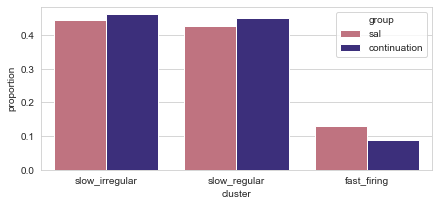

In [163]:
x, y, hue = "cluster", "proportion", "group"

plt.figure(figsize=(7, 3))
(neurons[x]
 .groupby(neurons[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)
 )
plt.savefig(FIG_DIR / "neuron props.svg")

MannwhitneyuResult(statistic=8222.5, pvalue=9.650443026464909e-08)

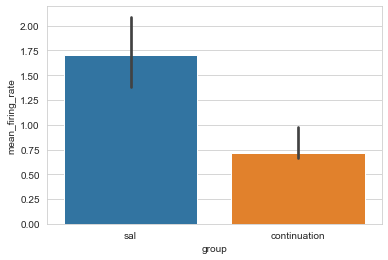

In [91]:
from scipy.stats import mannwhitneyu

sns.barplot(data=neurons.dropna(), x="group", y="mean_firing_rate", estimator=np.median)

mannwhitneyu(neurons.loc[lambda x: x.group == "sal"]["mean_firing_rate"], neurons.loc[lambda x: x.group == "continuation"]["mean_firing_rate"] )

SR: MannwhitneyuResult(statistic=1788.0, pvalue=0.0049300631063048436)
SIR: MannwhitneyuResult(statistic=1311.5, pvalue=3.8626367959035e-07)
FF: MannwhitneyuResult(statistic=127.0, pvalue=0.28457489704301175)


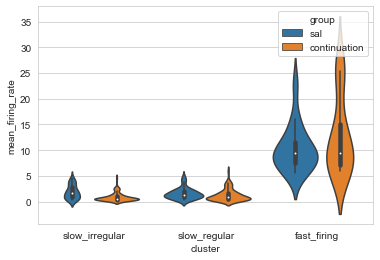

In [108]:
sns.violinplot(data=neurons.dropna(), x="cluster", y="mean_firing_rate", hue="group", estimator=np.median)


x = neurons.loc[lambda x: (x.group == "sal") & (x.cluster == "slow_regular")]["mean_firing_rate"]
y = neurons.loc[lambda x: (x.group == "continuation") & (x.cluster == "slow_regular")]["mean_firing_rate"]
sr = mannwhitneyu(x, y )
print(f"SR: {sr}")

x = neurons.loc[lambda x: (x.group == "sal") & (x.cluster == "slow_irregular")]["mean_firing_rate"]
y = neurons.loc[lambda x: (x.group == "continuation") & (x.cluster == "slow_irregular")]["mean_firing_rate"]
sir = mannwhitneyu(x, y )
print(f"SIR: {sir}")

x = neurons.loc[lambda x: (x.group == "sal") & (x.cluster == "fast_firing")]["mean_firing_rate"]
y = neurons.loc[lambda x: (x.group == "continuation") & (x.cluster == "fast_firing")]["mean_firing_rate"]
ff = mannwhitneyu(x, y )
print(f"FF: {ff}")

In [92]:
neurons[["session_name", "group"]].drop_duplicates()["group"].value_counts()

continuation    7
sal             5
Name: group, dtype: int64

In [65]:
neurons.drop_duplicates()["group"].value_counts()

continuation    202
sal             124
Name: group, dtype: int64

In [93]:
neurons.groupby(["group", "session_name"], as_index=False).apply(len)


,group,session_name,NaN
0,sal,chronic_09,8
1,sal,hamilton_01,15
2,sal,hamilton_07,46
3,sal,hamilton_13,11
4,sal,hamilton_19,44
5,continuation,chronic_01,19
6,continuation,chronic_08,26
7,continuation,hamilton_02,7
8,continuation,hamilton_08,42
9,continuation,hamilton_14,5


In [94]:
import numpy as np
def ster(x):
    return x.std()/np.sqrt(len(x))

neurons.groupby("group")["mean_firing_rate"].apply(lambda x: pd.Series({"ci": 1.96 * ster(x), "m": x.median()}))

group           
sal           ci    0.608913
              m     1.702556
continuation  ci    0.567800
              m     0.716406
Name: mean_firing_rate, dtype: float64

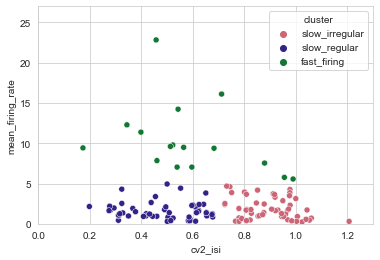

In [164]:
plt.figure(figsize=(6, 4))

dfp = neurons.loc[lambda x: x.group == "sal"]

colors= [ "#CC6677", "#332288", "#117733",]
sns.set_palette(sns.color_palette(colors))


ax = sns.scatterplot(x="cv2_isi", y="mean_firing_rate", hue="cluster", data=dfp)
ax.set_xlim([0, 1.3])
ax.set_ylim([0, 27])
plt.savefig(FIG_DIR / "scatter sal.svg")

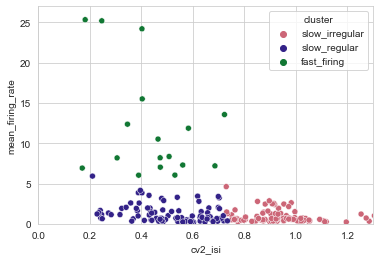

In [165]:
plt.figure(figsize=(6, 4))
dfp = neurons.loc[lambda x: x.group == "continuation"]

ax = sns.scatterplot(x="cv2_isi", y="mean_firing_rate", hue="cluster", data=dfp)
ax.set_xlim([0, 1.3])
ax.set_ylim([0, 27])
plt.savefig(FIG_DIR / "scatter cit.svg")

In [100]:
X = pd.crosstab(neurons["group"], neurons["cluster"])

In [101]:
from scipy.stats import chi2_contingency

chi2_contingency(X)

(1.3148779445037686,
 0.5181767015274522,
 2,
 array([[12.93251534, 56.29447853, 54.77300613],
        [21.06748466, 91.70552147, 89.22699387]]))

C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


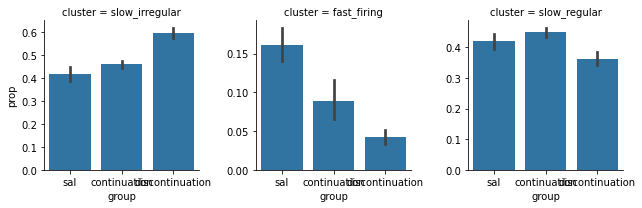

In [39]:
import pandas as pd
def prop_stats(df, cnames):
    out = {}
    for cname in cnames:
        out[cname] = (df["cluster"] == cname).mean()
    return pd.Series(out)

cnames = neurons.cluster.unique()

g = (
    neurons
    .groupby("session_name", as_index=False)
    .apply(prop_stats, cnames=cnames)
    .melt(id_vars="session_name", var_name="cluster", value_name="prop")
    .merge(neurons[["session_name", "group"]])
    .pipe(sns.FacetGrid, col="cluster", sharey=False, )
)
g.map(sns.barplot, "group", "prop",)

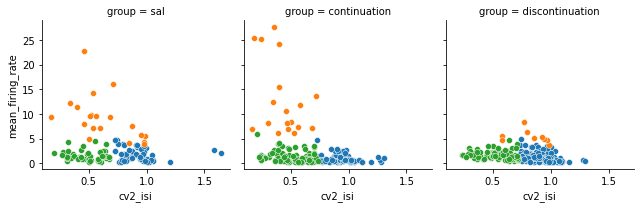

In [38]:
g = sns.FacetGrid(data=neurons, col="group", hue="cluster")
g.map(sns.scatterplot, "cv2_isi", "mean_firing_rate")

In [45]:
from citalopram_project.load import load_spikes

spikes = load_spikes("pre")
neurons = load_neurons().dropna()



In [49]:
def prop_stats(df, cnames):
    out = {}
    for cname in cnames:
        out[cname] = (df["cluster"] == cname).mean()
    return pd.Series(out)

cnames = neurons["cluster"].unique()
neurons.loc[lambda x: x.group=="sal"].groupby("session_name").apply(prop_stats, cnames).sort_values("slow_regular", ascending=False)

,slow_irregular,fast_firing,slow_regular
session_name,,,
hamilton_19,0.318182,0.136364,0.545455
hamilton_13,0.272727,0.272727,0.454545
hamilton_07,0.478261,0.108696,0.413043
chronic_09,0.125000,0.625000,0.250000
hamilton_01,0.800000,0.066667,0.133333


In [51]:
from spiketimes.df.conversion import df_to_list
from spiketimes.plots import grouped_raster

def get_spiketrains_by_categories(df_spikes):
    """
    Separate out a dataframe of spike times into 3 lists of spiketrains, one for each
    neuron group.
    
    Returns:
        SR, SIR, FF
    """
    _, slow_regs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

    _, slow_irregs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_irregular"],
                   spiketimes_col="spiketimes",
                   spiketrain_col="neuron_id")

    _, ffs = df_to_list(df_spikes[df_spikes["cluster"] == "fast_firing"],
                   spiketimes_col="spiketimes",
                   spiketrain_col="neuron_id")
    return slow_regs, slow_irregs, ffs

def plot_raster_by_group(slow_regs, slow_irregs, ffs, t_start, num_secs, ax):
    """
    Given 3 lists of spiketrains (one per neuron group), plots a raster plot
    with spiketrains grouped and colored by group.
    """
    t_stop = t_start + num_secs
    ax = grouped_raster([slow_regs, slow_irregs, ffs],
                        ["#332288", "#CC6677",  "#117733"],
                   t_start=t_start, t_stop=t_stop,
                        space_between_groups=1,
                   plot_kwargs={"s":90},
                       ax=ax)
    ax.set_yticklabels([])
    ax.set_xticks(ticks=[t_start, t_start+5, t_start+10])
    ax.set(frame_on=False)
    ax.set_ylabel("Unit", fontsize=24)
    ax.set_xlabel("Time [sec]", fontsize=24)
    return ax

In [56]:
df_spikes = spikes.merge(neurons[["neuron_id", "session_name", "cluster"]]).loc[lambda x: x.session_name == "hamilton_19"]
slow_regs, slow_irregs, ffs = get_spiketrains_by_categories(df_spikes)

<AxesSubplot:xlabel='Time [sec]', ylabel='Unit'>

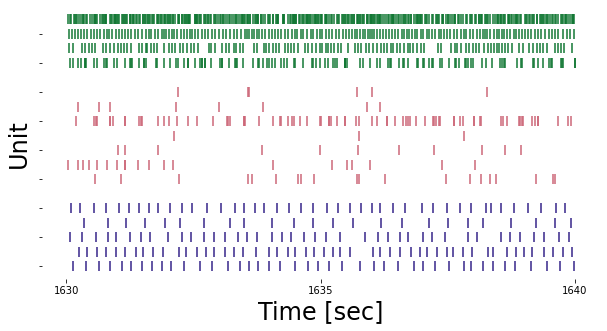

In [118]:
_, ax = plt.subplots(figsize=(10, 5))

s = [s for i, s in enumerate(slow_regs) if i in [0,  4, 5, 9,  20]]
plot_raster_by_group(
    s,
    slow_irregs[::2],
    ffs[:-2], 
    t_start=1630,
    num_secs=10,
    ax=ax
)